# 机器学习模型动态增量训练
除了推理过程有动态和静态之分，机器学习模型的训练过程也有动态和静态两类
* 静态模型采用离线训练方式。一般只训练模型一次，然后长时间使用该模型
* 动态模型采用在线训练方式。数据会不断进入系统，通过不断地更新系统将这些数据整合到模型中。scikit-learn中，支持增量训练的算法有：
    * sklearn.naive_bayes.MultinomialNB
    * sklearn.naive_bayes.BernoulliNB
    * sklearn.linear_model.Perceptron
    * sklearn.linear_model.SGDClassifier
    * sklearn.linear_model.PassiveAggressiveClassifier
    * sklearn.neural_network.MLPClassifier
    * sklearn.linear_model.SGDRegressor
    * sklearn.linear_model.PassiveAggressiveRegressor
    * sklearn.neural_network.MLPRegressor

In [1]:
# 使用人工神经网络来完成模型动态增量训练及部署过程
# 选择前面用过的 DIGITS 手写字符数据集
# 为了实验的需要，我们将手写字符矩阵中大于 0 的值全部替换为 1
import warnings

warnings.filterwarnings("ignore")

from sklearn.datasets import load_digits

digits = load_digits()  # 加载数据集

digits.data.shape, digits.target.shape

((1797, 64), (1797,))

In [2]:
# 切分数据集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=1, test_size=0.2
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [3]:
# 训练模型
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=1, verbose=1, max_iter=50)

model.fit(X_train, y_train)  # 训练模型
y_pred = model.predict(X_test)  # 测试模型
accuracy_score(y_test, y_pred)  # 准确度

Iteration 1, loss = 7.02205935
Iteration 2, loss = 3.65516147
Iteration 3, loss = 2.47679869
Iteration 4, loss = 1.49613624
Iteration 5, loss = 1.00259484
Iteration 6, loss = 0.72002813
Iteration 7, loss = 0.54341224
Iteration 8, loss = 0.43746627
Iteration 9, loss = 0.36224450
Iteration 10, loss = 0.30940686
Iteration 11, loss = 0.26808400
Iteration 12, loss = 0.23881533
Iteration 13, loss = 0.21317742
Iteration 14, loss = 0.19387023
Iteration 15, loss = 0.17858371
Iteration 16, loss = 0.16540074
Iteration 17, loss = 0.15237040
Iteration 18, loss = 0.14083022
Iteration 19, loss = 0.13015872
Iteration 20, loss = 0.12388636
Iteration 21, loss = 0.11475134
Iteration 22, loss = 0.10716270
Iteration 23, loss = 0.10093849
Iteration 24, loss = 0.09392212
Iteration 25, loss = 0.08891589
Iteration 26, loss = 0.08473752
Iteration 27, loss = 0.08024667
Iteration 28, loss = 0.07630452
Iteration 29, loss = 0.07093241
Iteration 30, loss = 0.06705022
Iteration 31, loss = 0.06426208
Iteration 32, los

0.975

In [4]:
# 寻找被模型错误预测的样本
n = 0
for i, (pred, test) in enumerate(zip(y_pred, y_test)):
    if pred != test:
        print("样本索引:", i, "被错误预测为: ", pred, "正确标签为: ", test)
        n += 1
print("总计错误预测样本数量:", n)

样本索引: 21 被错误预测为:  4 正确标签为:  1
样本索引: 58 被错误预测为:  9 正确标签为:  5
样本索引: 88 被错误预测为:  9 正确标签为:  5
样本索引: 173 被错误预测为:  5 正确标签为:  8
样本索引: 208 被错误预测为:  4 正确标签为:  0
样本索引: 281 被错误预测为:  4 正确标签为:  0
样本索引: 321 被错误预测为:  4 正确标签为:  7
样本索引: 347 被错误预测为:  5 正确标签为:  8
样本索引: 348 被错误预测为:  3 正确标签为:  5
总计错误预测样本数量: 9


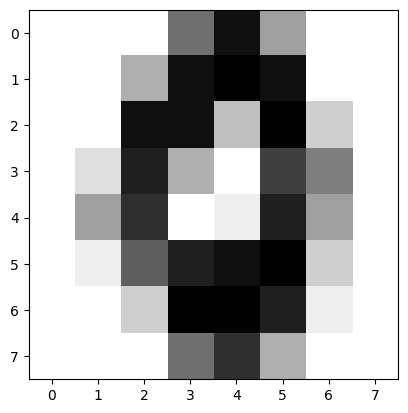

In [6]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.imshow(X_test[208].reshape((8, 8)), cmap=plt.cm.gray_r)

In [15]:
# 利用上面已经训练好的模型，对错误预测样本进行增量学习
import numpy as np

addition_index = []
for i, (pred, test) in enumerate(zip(y_pred, y_test)):
    if pred != test:
        addition_index.append(i)

addition_X = X_test[addition_index]  # 错误预测样本特征
addition_y = y_test[addition_index]  # 错误预测样本正确标签

# 增量训练模型
model.partial_fit(addition_X, addition_y)
model

Iteration 1, loss = 0.92234781


MLPClassifier(max_iter=50, random_state=1, verbose=1)

In [16]:
y_pred = model.predict(X_test)  # 测试模型
accuracy_score(y_test, y_pred)  # 准确度

# 打印错误预测样本
n = 0
for i, (pred, test) in enumerate(zip(y_pred, y_test)):
    if pred != test:
        print("样本索引:", i, "被错误预测为: ", pred, "正确标签为: ", test)
        n += 1
print("总计错误预测样本数量:", n)

样本索引: 25 被错误预测为:  7 正确标签为:  9
样本索引: 112 被错误预测为:  3 正确标签为:  8
总计错误预测样本数量: 2


In [25]:
# 构建一个可以部署到线上的手写字符识别系统，使之可以实现对用户绘制的字符进行预测
from IPython.display import HTML

input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 43px; height: 44px;">
<canvas width="40" height="40"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">重绘</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 8*8; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 5, 5);
            x = Math.floor(e.offsetY * 0.2);
            y = Math.floor(e.offsetX * 0.2) + 1;
            for (var dy = 0; dy < 1; dy++){
                for (var dx = 0; dx < 1; dx++){
                    if ((x + dx < 8) && (y + dy < 8)){
                        pixels[(y+dy)+(x+dx)*8] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value();
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 8*8; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
        kernel.execute("f = open('digits.json', 'w')");
        kernel.execute("f.write('{\\"inputs\\":%s}' % image)");
        kernel.execute("f.close()");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 40, 40);
        for (var i = 0; i < 8*8; i++) pixels[i] = 0;
    }
</script>
"""
randint = np.random.randint(0, 9)
print(f"请在下方图框中细心绘制手写字符 {randint}")
HTML(input_form + javascript)

请在下方图框中细心绘制手写字符 0


In [24]:
import json
import numpy as np

with open("digits.json") as f:
    inputs = f.readlines()[0]
    inputs_array = np.array(json.loads(inputs)["inputs"])
plt.imshow(inputs_array.reshape((8, 8)), cmap=plt.cm.gray_r)

FileNotFoundError: [Errno 2] No such file or directory: 'digits.json'

In [22]:
# 重新训练神经网络
digits.data[digits.data > 0] = 1
model = MLPClassifier(tol=0.001, max_iter=50, verbose=1)
model.fit(digits.data, digits.target)

Iteration 1, loss = 2.33363985
Iteration 2, loss = 2.08982732
Iteration 3, loss = 1.89686434
Iteration 4, loss = 1.70159790
Iteration 5, loss = 1.51086417
Iteration 6, loss = 1.32987414
Iteration 7, loss = 1.16819635
Iteration 8, loss = 1.02843916
Iteration 9, loss = 0.91276721
Iteration 10, loss = 0.81607453
Iteration 11, loss = 0.74040782
Iteration 12, loss = 0.67678304
Iteration 13, loss = 0.62696020
Iteration 14, loss = 0.58365877
Iteration 15, loss = 0.54808907
Iteration 16, loss = 0.51219196
Iteration 17, loss = 0.48753634
Iteration 18, loss = 0.46434023
Iteration 19, loss = 0.44360570
Iteration 20, loss = 0.42564876
Iteration 21, loss = 0.40985156
Iteration 22, loss = 0.39616812
Iteration 23, loss = 0.37956035
Iteration 24, loss = 0.36886581
Iteration 25, loss = 0.35643353
Iteration 26, loss = 0.34569561
Iteration 27, loss = 0.33689180
Iteration 28, loss = 0.32784394
Iteration 29, loss = 0.31921020
Iteration 30, loss = 0.31114951
Iteration 31, loss = 0.30585458
Iteration 32, los

MLPClassifier(max_iter=50, tol=0.001, verbose=1)

In [23]:
inputs_array = np.atleast_2d(inputs_array)  # 将其处理成 2 维数组
result = model.predict(inputs_array)  # 预测

if result != randint:
    print(f"预测错误｜预测标签: {result}｜真实标签: {randint}")
    model.partial_fit(inputs_array, np.atleast_1d(randint))
    print("完成增量训练")
else:
    print(f"预测正确｜预测标签: {result}｜真实标签: {randint}")
    model.partial_fit(inputs_array, np.atleast_1d(randint))
    print("完成增量训练")

NameError: name 'inputs_array' is not defined